In [25]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from langdetect import detect
from logs.best_topic_names import topic_col, emotion_col, style_col
import matplotlib.dates as md
import plotly.express as px
import spacy
import textdescriptives as td

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Structure
Content and narratives
- Topic modeling of EU Commission tweets
- Which topics generate most engagement (likes, comments, retweets, quotes)? 
- Which topics generate most positive comments? 
- Which narratives resonate the most?

Styles
- How is the style of the European commission tweeting? Is it related to engagement? [TODO]

Emotional content
- What is the prevalent emotional content? [TODO]

Comparison
- Which are the best predictors of engagement?
    - Bag of words models [TODO]
    - Topic models [TODO]
    - Transformer-based models (static) [TODO]
    - Stylistic predictors [TODO]
    - Emotion predictors [TODO]
    
### Meta:
- Extend to other languages?
- Extend to other accounts?

### Load data and extract additional features

In [11]:
df = pd.read_json(f'logs/topic/distilbert-base-uncased-finetuned-sst-2-english_vocab-500_bow-499_comp-20_esize-768_batch-64_lr-0.002_epochs-100_act-softplus/topic_preds_1.jsonl',
                  orient='records', 
                  lines=True)
df.rename(dict(zip([f'topic_{i}' for i in range(20)], topic_col)), inplace=True, axis=1)
df['top_topic'] = df[topic_col].apply(lambda x: topic_col[x.argmax()], axis=1)
response_df = pd.read_json('processed/pre_topic_responses_sentiment.jsonl', 
                           orient='records', 
                           lines=True)   

Extract style descriptors

In [15]:
nlp = spacy.load("en_core_web_md")
nlp.add_pipe("textdescriptives")

dfs = [] 
for t in topic_20d['text']:
    try: 
        extracted = td.extract_df(nlp(t))
        dfs.append(extracted) 
    except:
        dfs.append(pd.DataFrame([[np.nan]*len(extracted.columns)],
                                columns=extracted.columns))

/home/roberta/venvs/tw-langmod/lib/python3.8/site-packages/spacy/util.py:865: UserWarning: [W095] Model 'en_core_web_md' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [27]:
df = pd.concat([df, pd.concat(dfs).reset_index(drop=True).drop('text',
                                                               axis=1)], axis=1)

<ipython-input-27-9894320def15>:1: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df, pd.concat(dfs).reset_index(drop=True).drop('text',


In [278]:
#df.to_json('processed/post_topic_tweets_style.jsonl', orient='records', lines=True)
df = pd.read_json('processed/post_topic_tweets_style.jsonl', orient='records', lines=True)

Extract emotions

In [279]:
from transformers import pipeline
classifier = pipeline("text-classification", 
                      model='cardiffnlp/twitter-roberta-base-sentiment',
                      #model="j-hartmann/emotion-english-distilroberta-base", 
                      return_all_scores=True, device=0,
                      function_to_apply='softmax'
                     )

In [280]:
def get_emo(lst):
    columns = [l['label'] for l in lst]
    vals = [l['score'] for l in lst]
    return pd.DataFrame([vals], columns=columns)

In [281]:
%%capture 
emos = pd.concat(df['text'].apply(lambda x: 
                                  get_emo(classifier(x)[0])).tolist())

In [282]:
df = pd.concat([df, emos.reset_index(drop=True)], axis=1)
df.rename({'LABEL_0': 'negative_sentiment', 
           'LABEL_1': 'neutral_sentiment',
           'LABEL_2': 'positive_sentiment'}, 
          axis=1,
          inplace=True)

In [283]:
df.to_json('processed/post_topic_tweets_style_and_sent.jsonl', orient='records', lines=True)
#df = pd.read_json('processed/post_topic_tweets_style_and_sent.jsonl', orient='records', lines=True)

### Engagement by style

In [284]:
import numpy as np
from sklearn.decomposition import PCA
X = df.fillna(0)[df.columns[34:78]]
pca = PCA(n_components=44)
pca.fit(X)

PCA(n_components=44)

In [285]:
pca.explained_variance_ratio_.round(4)

array([8.323e-01, 1.295e-01, 1.730e-02, 9.900e-03, 4.100e-03, 1.700e-03,
       1.300e-03, 1.100e-03, 8.000e-04, 6.000e-04, 5.000e-04, 3.000e-04,
       2.000e-04, 1.000e-04, 1.000e-04, 1.000e-04, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00])

Let's interpret the first 5 dimensions.

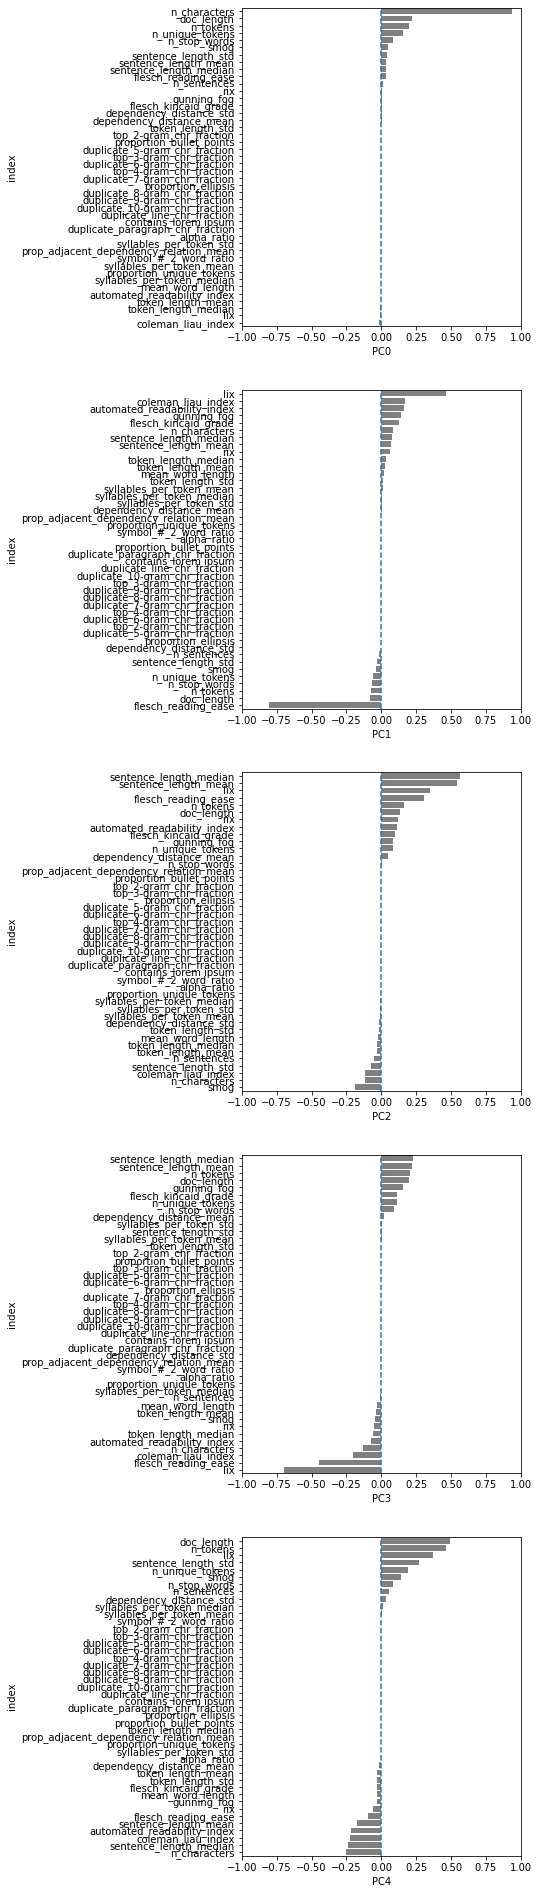

In [286]:
loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i}' for i in range(44)], 
                        index=df.columns[34:78])
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(5,34))
for i, c in enumerate([f'PC{i}' for i in range(5)]):
    sns.barplot(data=loadings.reset_index().sort_values(by=c, ascending=False), 
                y='index', x=c, ax=ax[i], color='grey')
    ax[i].axvline(0, linestyle='--')
    ax[i].set_xlim(-1,1)
plt.show()

PC0 simply quantifies length. PC1 seems to express readability in general. <br>
PC2 quantifies sentence-level (and document-level) complexity vs. token-level complexity. <br>
PC3, PC4, etc, capture more complex relations between readability and length.

In [287]:
new_dims = pd.DataFrame(pca.transform(X),
                        columns=[f'style_dim_{i}' for i in range(44)])
df = pd.concat([df, new_dims], axis=1)

In [288]:
df.to_json('processed/post_topic_tweets_style_and_sent_pca.jsonl', 
           orient='records', 
           lines=True)
#df = pd.read_json('processed/post_topic_tweets_style_and_sent_pca.jsonl', orient='records', lines=True)

### Sentiment

In [301]:
freq_dict = {'D': 'day', 'W': 'week', 'M': 'month'}
figsizes = {'D': (50,5), 'W': (27,5), 'M': (30, 5)}
formats = {'D': '%Y-%m-%d', 'W': '%Y-%m-%d', 'M': '%Y-%m'}
colors = ['indianred', 'grey', sns.color_palette()[0]]


def plot_volume(freq='D', roll_window=7, outcomes=[]):
    fig, ax = plt.subplots(figsize=figsizes[freq])
    grouper = pd.Grouper(key='created_at', axis=0, freq=freq)
    grouped = df.groupby(grouper).mean().reset_index()
    for i,s in enumerate(outcomes):
        grouped[f'{s}_smoothed'] = grouped[s].rolling(roll_window,
                                                      min_periods=1).mean()
        sns.lineplot(data=grouped, 
                     x='created_at', 
                     y=s, 
                     alpha=.2,
                     color=colors[i])
        sns.lineplot(data=grouped, 
                     x='created_at', 
                     y=f'{s}_smoothed', 
                     label=s.replace('_',' ').capitalize(), 
                     color=colors[i])
    plt.ylabel(f'Score')
    plt.xlabel('')
    plt.title(f'Sentiment')
    plt.xticks(rotation=60)
    # Make year boundaries
    for d in grouped.created_at.dt.year.unique():
        plt.axvline(x=np.datetime64(f'{d}-01-01'), color='darkgrey', linestyle='--')
        plt.annotate(text=d, xy=(np.datetime64(f'{d}-06-01'),.97), color='black')
    ax.xaxis.set_major_locator(md.MonthLocator()) # (1,7)
    ax.xaxis.set_major_formatter(md.DateFormatter('%b \'%y'))
    plt.xlim(np.datetime64('2010-05-01'),np.datetime64('2022-08-01'))
    #plt.savefig(f'figures/sentiment_over_time.pdf')
    plt.show()

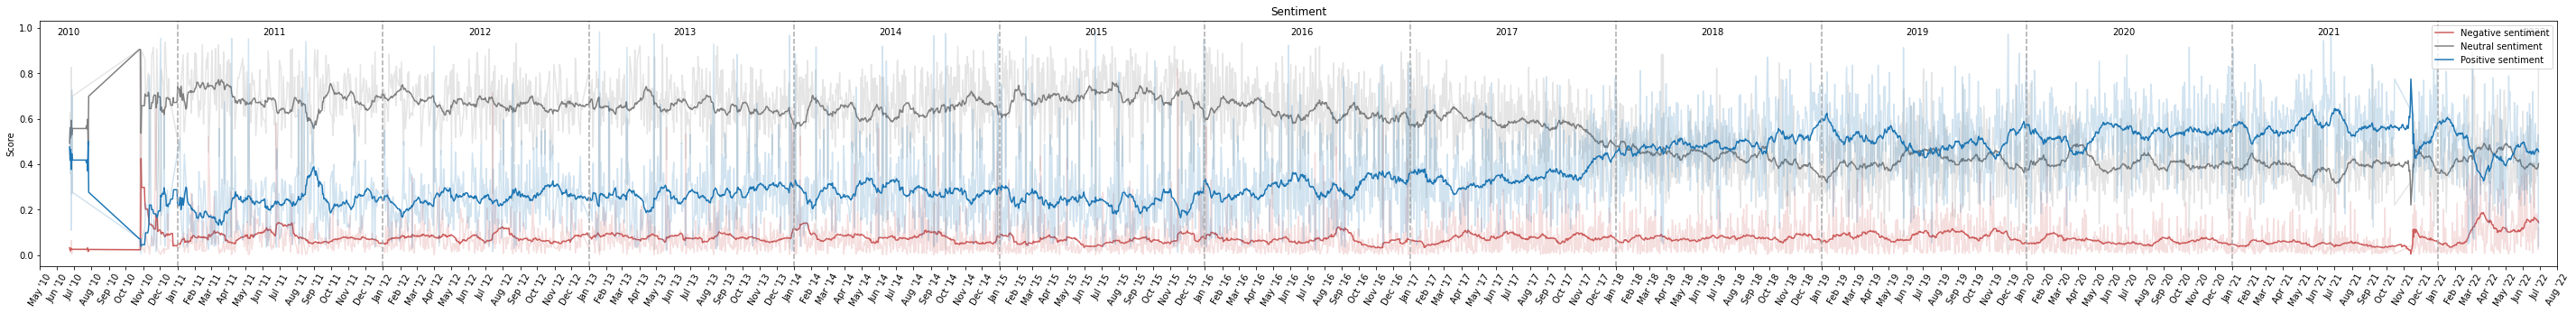

In [302]:
plot_volume(freq='D',roll_window=30, outcomes=['negative_sentiment', 
                                               'neutral_sentiment',
                                               'positive_sentiment'])

#### Results of predictive models

In [333]:
dfs = []
for metric in ['like', 'retweet']:
    fs = glob.glob(f'logs/metrics/{metric}_count/pred*.pkl')
 
    for f in fs:
        dfs.append(pd.read_pickle(f))
    metrics = pd.concat(dfs)

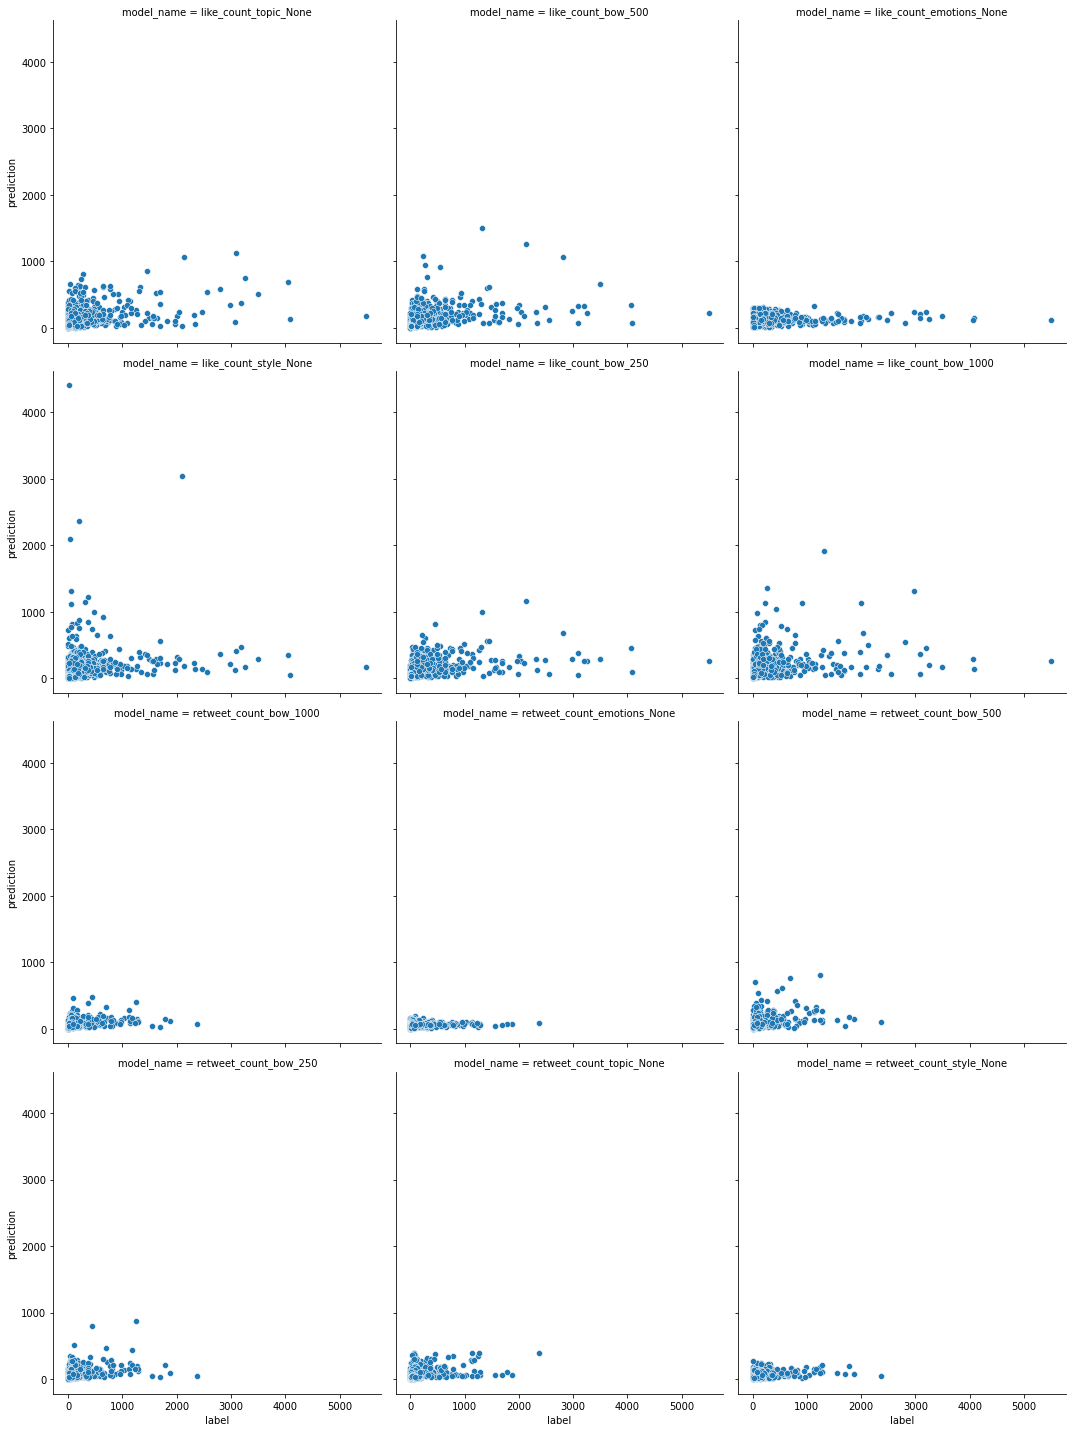

In [334]:
#sns.relplot(data=metrics[metrics['split']=='test'], 
#            x='label', y='prediction', 
#            col='model_name',
#            col_wrap=3)

### Predictive models

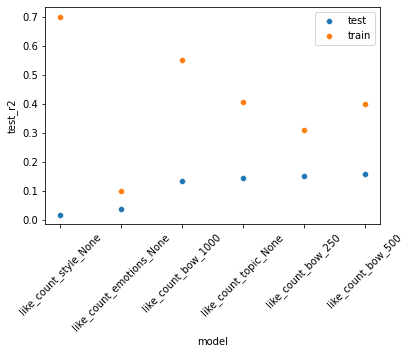

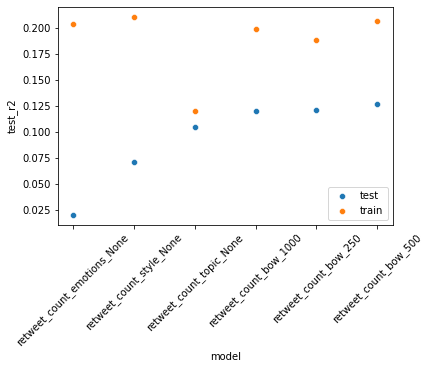

In [24]:
for metric in ['like', 'retweet']:
    data = pd.DataFrame(json.load(open(f'logs/metrics/{metric}_count.json')))
    for out_metric in ['r2']:
        data = data.sort_values(by=f'test_{out_metric}', ascending=True)
        for split in ['test', 'train']:
            sns.scatterplot(data=data, x='model', y=f'{split}_{out_metric}', label=split)
        plt.xticks(rotation=45)
        plt.show()

***** like *****


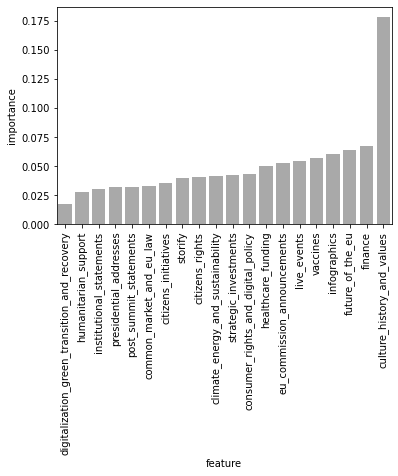

***** quote *****


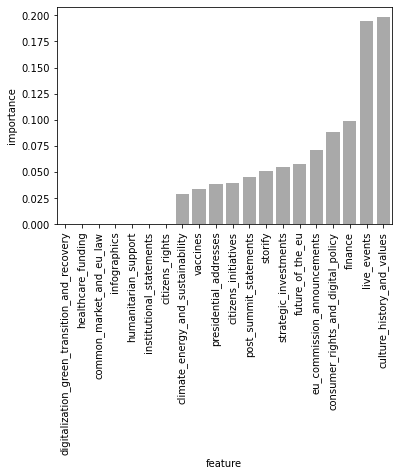

***** reply *****


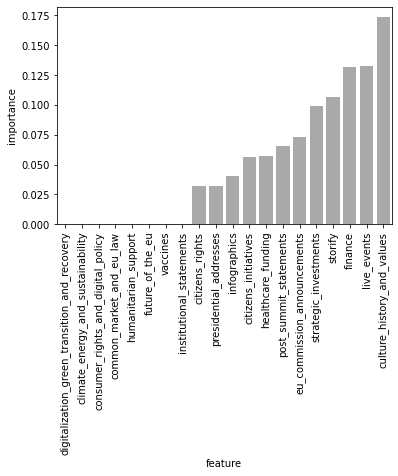

***** retweet *****


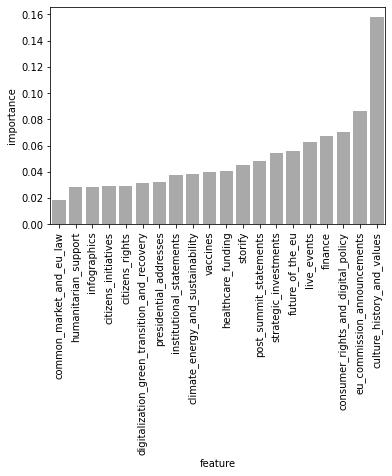

In [23]:
import pickle as pkl
import xgboost
with xgboost.config_context(verbosity=0):
    for metric in ['like', 'quote', 'reply', 'retweet']:
        print(f'***** {metric} *****')
        fnames = glob.glob(f'logs/metrics/{metric}_count/{metric}_count_topic*.pkl')
        for m in fnames:
            model = pkl.load(open(m, 'rb'))
            if 'topic' in m:
                feature_names = topic_col
            else:
                bow_nr = m.split('_')[-1].split('.')[0]
                tokenizer = pkl.load(open(f'logs/metrics/{metric}_count/tokenizer_bow-{bow_nr}.pkl',
                                          'rb'))
                feature_names = tokenizer.index_word.values()
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            if not 'topic' in m:
                df = df.tail(n=50)
                fig, ax = plt.subplots(figsize=(20,4))
            sns.barplot(data=df, x='feature', y='importance', color='darkgrey')
            plt.xticks(rotation=90)
            plt.show()
    

### Predictive models

In [19]:
# TODO